## Basic Training

In [37]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report

import numpy as np
import pandas as pd

In [2]:
hmhas = pd.read_csv('dataset/h_mas_train.csv')

In [3]:
# Drop Index

hmhas = hmhas.drop('Unnamed: 0', axis=1)

In [4]:
hmhas.columns

Index(['cholst', 'mobila', 'hrtatte', 'push', 'bmi', 'walks', 'rxhrtat',
       'grossa', 'walkr', 'rxdiabi', 'hip_m', 'hhid', 'mobilsev', 'fallinj',
       'agey', 'wtresp', 'rxhibp', 'ctot1m', 'hltc', 'weight', 'grossaa',
       'momage', 'height', 'bath', 'dadage', 'shlt', 'ahous', 'batha', 'lift',
       'walksa', 'livsib', 'aothr', 'grchild', 'vscan', 'pusha', 'adltot_m',
       'adla', 'hosp1y', 'genderf', 'rxhibp.1', 'cncrsurg', 'rxstrok',
       'rxarthr', 'rxlung_m'],
      dtype='object')

   hosp1y  Total
0     0.0  84050
1     1.0  11508


<AxesSubplot: xlabel='Total', ylabel='hosp1y'>

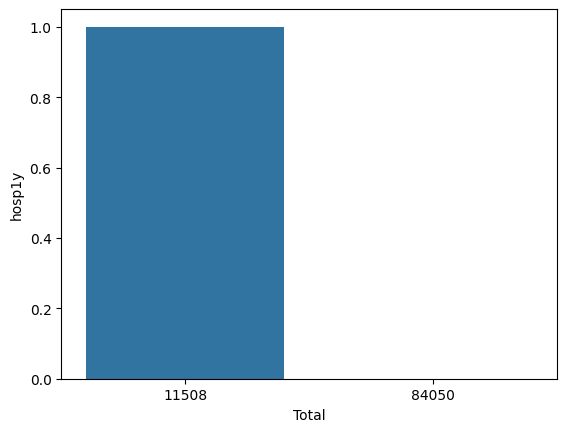

In [5]:
# Evaluate The Target Variable

import seaborn as sns
import matplotlib.pyplot as plt

df = hmhas

df_target = df.groupby(['hosp1y']).size().to_frame('Total').reset_index('hosp1y')

print(df_target)

sns.barplot(x='Total', y='hosp1y', data=df_target)


In [6]:
hmhas.shape

(95558, 44)

# Preprocessing

In [13]:
df = hmhas

from sklearn.model_selection import train_test_split

X_train = df.drop("hosp1y", axis=1)

# Assign the 'target' column to y_train

y_train = df["hosp1y"]

# Remove the 'target' column for test
X_test = df.drop("hosp1y", axis=1)

# Assign the 'target' column to y_test
y_test = df["hosp1y"]

# separate dataset into train and test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)


In [14]:
# Drop Categorical :
categorical_cols = X_train.select_dtypes(include=['object']).columns

X_train = X_train.drop(categorical_cols, axis=1)
X_test = X_test.drop(categorical_cols, axis=1)
X_val = X_val.drop(categorical_cols, axis=1)

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Impute values for all columns with missing data
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(X_train)

n_train_df = imp_mean.transform(X_train)
t_val_df = imp_mean.transform(X_val)
t_test_df = imp_mean.transform(X_test)

# Scaling all Numerical features

scaler = StandardScaler()
scaler = scaler.fit(n_train_df)

t_train_df = scaler.transform(n_train_df)
t_val_df = scaler.transform(t_val_df)
t_test_df = scaler.transform(t_test_df)


In [10]:
%%time

#   - Create and fit (train) a Logistic Regression

log_reg = None
log_reg = LogisticRegression(C=0.01)
log_reg.fit(t_train_df, y_train)


CPU times: total: 1.67 s
Wall time: 818 ms


LogisticRegression(C=0.01)

In [11]:
log_reg_train = log_reg.predict_proba(t_train_df)[:, 1]

In [12]:
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)

print(f"Train ROC AUC Score: {roc_auc_train:.4f}") 

Train ROC AUC Score: 0.7391


# Multiple Training

In [13]:
import lightgbm as lgb

In [14]:
%%time

models = {
    "Logistic Regression": LogisticRegression(C=0.001),
    "      Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "      LGBClassifier ": lgb.LGBMClassifier(learning_rate=0.2)
}

for name, model in models.items():
    model.fit(t_train_df, y_train)
    print(name + " trained.")

Logistic Regression trained.
      Random Forest trained.
[LightGBM] [Info] Number of positive: 9248, number of negative: 67198
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3329
[LightGBM] [Info] Number of data points in the train set: 76446, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120974 -> initscore=-1.983236
[LightGBM] [Info] Start training from score -1.983236
      LGBClassifier  trained.
CPU times: total: 32.3 s
Wall time: 32.2 s


# Results

In [15]:
for name, model in models.items():
    y_pred = model.predict(t_test_df)
    acc = accuracy_score(y_test, y_pred)
    print(name + " Accuracy: {:.2f}%".format(acc * 100))

Logistic Regression Accuracy: 88.10%
      Random Forest Accuracy: 89.25%
      LGBClassifier  Accuracy: 90.32%


In [16]:
for name, model in models.items():
    y_pred = model.predict(t_test_df)
    f1 = f1_score(y_test, y_pred)
    print(name + " F1-Score: {:.5f}".format(f1))

Logistic Regression F1-Score: 0.11047
      Random Forest F1-Score: 0.19866
      LGBClassifier  F1-Score: 0.35976


## Neural NetWork Training

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [25]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [36]:
model = Sequential()

model.add(Flatten())

model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=5e-4), metrics=['accuracy'])    

epochs = 30
batch_size = 64

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{accuracy:.3f}.h5', save_best_only=True),
]

model.fit(t_train_df, y_train, class_weight=class_weight_dict, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=my_callbacks)

mlp = model

# Send the input data through the trained model to get the predictions
predictions = mlp.predict(t_test_df)

Epoch 1/30
1076/1076 [==============================] - 6s 5ms/step - loss: 0.6025 - accuracy: 0.6787 - val_loss: 0.6246 - val_accuracy: 0.6498
Epoch 2/30
1076/1076 [==============================] - 6s 6ms/step - loss: 0.5853 - accuracy: 0.6948 - val_loss: 0.6588 - val_accuracy: 0.6320
Epoch 3/30
1076/1076 [==============================] - 5s 5ms/step - loss: 0.5767 - accuracy: 0.7024 - val_loss: 0.6226 - val_accuracy: 0.6841
Epoch 4/30
1076/1076 [==============================] - 6s 6ms/step - loss: 0.5666 - accuracy: 0.7134 - val_loss: 0.5203 - val_accuracy: 0.7533
Epoch 5/30
1076/1076 [==============================] - 6s 5ms/step - loss: 0.5526 - accuracy: 0.7231 - val_loss: 0.5596 - val_accuracy: 0.7233
Epoch 6/30
1076/1076 [==============================] - 6s 5ms/step - loss: 0.5364 - accuracy: 0.7350 - val_loss: 0.5240 - val_accuracy: 0.7434
Epoch 7/30
1076/1076 [==============================] - 6s 5ms/step - loss: 0.5182 - accuracy: 0.7509 - val_loss: 0.5125 - val_accuracy:

In [37]:
mlp.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 43)                0         
                                                                 
 dense_15 (Dense)            (None, 512)               22528     
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 154,113
Trainable params: 154,113
Non-trainable params: 0
_________________________________________________________________


In [38]:
predictions

array([[2.9958355e-01],
       [1.2493670e-02],
       [1.9377916e-05],
       ...,
       [4.7618151e-04],
       [3.4084022e-03],
       [8.5272580e-02]], dtype=float32)

## Classification Report

In [39]:
# Extract the probabilities

p_pred = predictions.flatten()

# Extract the Class labels
y_pred = np.where(p_pred > 0.5, 1, 0)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     84050
         1.0       0.73      0.89      0.80     11508

    accuracy                           0.95     95558
   macro avg       0.86      0.92      0.89     95558
weighted avg       0.95      0.95      0.95     95558



## Confusion Matrix

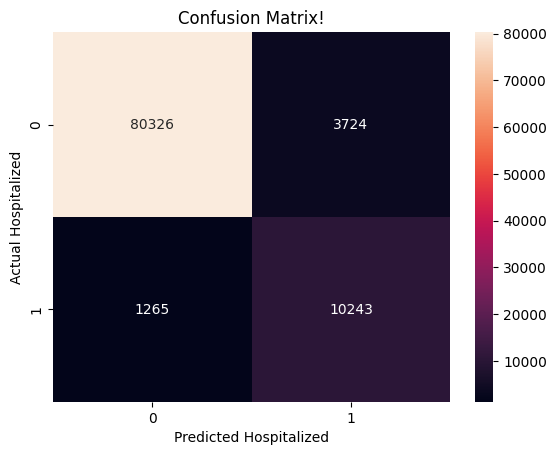

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

matc=confusion_matrix(y_test, y_pred)

ax = sns.heatmap(matc, annot=True, fmt='g')

ax.set_title('Confusion Matrix!')
ax.set_xlabel('Predicted Hospitalized')
ax.set_ylabel('Actual Hospitalized')

# Plot the confusion matrix

plt.show()

In [41]:
roc_auc_train = roc_auc_score(y_true=y_test, y_score=predictions)

print(f"Train ROC AUC Score: {roc_auc_train:.4f}") 

Train ROC AUC Score: 0.9525


## Model Test

In [2]:
# Assuming The Model Saved Has this name, Load For Predictions

model = keras.models.load_model('model.25-0.945.h5')

In [3]:
import numpy as np

input_data = [1,2,2,2,2,2,2,2,2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4]

input_data = np.expand_dims(input_data, axis=0)  # Adding an extra dimension for batch size

len(input_data[0]) 


43

In [4]:
pred_probability = model.predict(input_data)

print(pred_probability)

[[0.9691882]]


In [13]:
threshold = 0.9
if pred_probability >= threshold:
    prediction = "This person needs to be hospitalized next year."
else:
    prediction = "This person does not need to be hospitalized"

score = (pred_probability*100)


In [14]:
print(prediction)

score = np.around(score, 2)

s = str(score)
chars = [']', '['] 
result = s.translate(str.maketrans('', '', ''.join(chars)))
print('Score is '+result)    

The person has to hospitalize next year.
Score is 96.92
